In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import zipfile
%matplotlib inline

In [2]:
zf = zipfile.ZipFile('lec9data.zip', 'r')
zf.extractall()

## Canonicalization

In [3]:
with open('county_and_state.csv') as f:
    county_and_state = pd.read_csv(f)
    
with open('county_and_population.csv') as f:
    county_and_pop = pd.read_csv(f)    

Suppose we'd like to join these two tables. Unfortunately, we can't, because the strings representing the county names don't match, as seen below.

In [4]:
county_and_state

,County,State
0,De Witt County,IL
1,Lac qui Parle County,MN
2,Lewis and Clark County,MT
3,St John the Baptist Parish,LS


In [5]:
county_and_pop

,County,Population
0,DeWitt,16798
1,Lac Qui Parle,8067
2,Lewis & Clark,55716
3,St. John the Baptist,43044


 Before we can join them, we'll do what I call **canonicalization**.

Canonicalization: A process for converting data that has more than one possible representation into a "standard", "normal", or canonical form (definition via Wikipedia).

In [6]:
def canonicalize_county(county_name):
    return (
        county_name
        .lower()               # lower case
        .replace(' ', '')      # remove spaces
        .replace('&', 'and')   # replace &
        .replace('.', '')      # remove dot
        .replace('county', '') # remove county
        .replace('parish', '') # remove parish
    )

In [7]:
county_and_pop['clean_county'] = county_and_pop['County'].map(canonicalize_county)
county_and_state['clean_county'] = county_and_state['County'].map(canonicalize_county)

In [8]:
county_and_pop.merge(county_and_state,
                     left_on = 'clean_county', right_on = 'clean_county')

,County_x,Population,clean_county,County_y,State
0,DeWitt,16798,dewitt,De Witt County,IL
1,Lac Qui Parle,8067,lacquiparle,Lac qui Parle County,MN
2,Lewis & Clark,55716,lewisandclark,Lewis and Clark County,MT
3,St. John the Baptist,43044,stjohnthebaptist,St John the Baptist Parish,LS


## Processing Data from a Text Log Using Basic Python

In [9]:
with open('log.txt', 'r') as f:
    log_lines = f.readlines()

In [10]:
log_lines

['169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n',
 '193.205.203.3 - - [2/Feb/2005:17:23:6 -0800] "GET /stat141/Notes/dim.html HTTP/1.0" 404 302 "http://eeyore.ucdavis.edu/stat141/Notes/session.html"\n',
 '169.237.46.240 - "" [3/Feb/2006:10:18:37 -0800] "GET /stat141/homework/Solutions/hw1Sol.pdf HTTP/1.1"\n']

Suppose we want to extract the day, month, year, hour, minutes, seconds, and timezone. Looking at the data, we see that these items are not in a fixed position relative to the beginning of the string. That is, slicing by some fixed offset isn't going to work.

In [11]:
log_lines[0][20:31]

'26/Jan/2014'

In [12]:
log_lines[1][20:31]

'/Feb/2005:1'

Instead, we'll need to use some more sophisticated thinking. Let's focus on only the first line of the file.

In [13]:
first = log_lines[0]
first

'169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n'

In [14]:
pertinent = first.split("[")[1].split(']')[0]
day, month, rest = pertinent.split('/')
year, hour, minute, rest = rest.split(':')
seconds, time_zone = rest.split(' ')
day, month, year, hour, minute, seconds, time_zone

('26', 'Jan', '2014', '10', '47', '58', '-0800')

A much more sophisticated but common approach is to extract the information we need using a regular expression. See [today's lecture slides](https://docs.google.com/presentation/d/1omFKPsCaPf58VLo33U9ipRq4vt1Kj_3y9yHDUl8qYhk/edit#slide=id.g41d831233f_1_119) for more on regular expressions.

In [15]:
import re
pattern = r'\[(\d+)/(\w+)/(\d+):(\d+):(\d+):(\d+) (.+)\]'
day, month, year, hour, minute, second, time_zone = re.search(pattern, first).groups()
year, month, day, hour, minute, second, time_zone

('2014', 'Jan', '26', '10', '47', '58', '-0800')

Or alternately using the `findall` method:

In [16]:
import re
pattern = r'\[(\d+)/(\w+)/(\d+):(\d+):(\d+):(\d+) (.+)\]'
day, month, year, hour, minute, second, time_zone = re.findall(pattern, first)[0]
year, month, day, hour, minute, second, time_zone

('2014', 'Jan', '26', '10', '47', '58', '-0800')

Note: We can return the results as a Series:

In [17]:
cols = ["Day", "Month", "Year", "Hour", "Minute", "Second", "Time Zone"]
def log_entry_to_series(line):
    return pd.Series(re.search(pattern, line).groups(), index = cols)

log_entry_to_series(first)

Day             26
Month          Jan
Year          2014
Hour            10
Minute          47
Second          58
Time Zone    -0800
dtype: object

And using this function we can create a DataFrame of all the time information.

In [18]:
log_info = pd.DataFrame(columns=cols)

for line in log_lines:
    log_info = log_info.append(log_entry_to_series(line), ignore_index = True)

log_info

,Day,Month,Year,Hour,Minute,Second,Time Zone
0,26,Jan,2014,10,47,58,-0800
1,2,Feb,2005,17,23,6,-0800
2,3,Feb,2006,10,18,37,-0800


### Regular Expression From Lecture

Fill in the regex below so that after code executes, day is “26”, month is “Jan”, and year is “2014”. 

In [19]:
log_lines[0]

'169.237.46.168 - - [26/Jan/2014:10:47:58 -0800] "GET /stat141/Winter04/ HTTP/1.1" 200 2585 "http://anson.ucdavis.edu/courses/"\n'

In [20]:
pattern = r"YOUR REGEX HERE"
matches = re.findall(pattern, log_lines[0])
day, month, year = matches[0]
day, month, year

IndexError: list index out of range

## Real World Example #1: Restaurant Data

In this example, we will show how regexes can allow us to track quantitative data across categories defined by the appearance of various text fields.

In this example we'll see how the presence of certain keywords can affect quantitative data, e.g. how do restaurant health scores vary as a function of the number of violations that mention "vermin"?

In [29]:
vio = pd.read_csv('violations.csv', header=0, names=['id', 'date', 'desc'])
desc = vio['desc']
vio.head()

,id,date,desc
0,19,20171211,Inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...
3,19,20160513,Unclean or degraded floors walls or ceilings ...
4,19,20160513,Food safety certificate or food handler card n...


In [30]:
counts = desc.value_counts()

counts[:10]

Unclean or degraded floors walls or ceilings                          999
Unapproved or unmaintained equipment or utensils                      659
Inadequately cleaned or sanitized food contact surfaces               493
Improper food storage                                                 476
Inadequate and inaccessible handwashing facilities                    467
Moderate risk food holding temperature                                452
Wiping cloths not clean or properly stored or inadequate sanitizer    418
Moderate risk vermin infestation                                      374
Unclean nonfood contact surfaces                                      369
Food safety certificate or food handler card not available            353
Name: desc, dtype: int64

In [31]:
# Hmmm...
counts[50:60]

Inadequate HACCP plan record keeping                                                                 16
Moderate risk food holding temperature   [ date violation corrected: 10/11/2016 ]                    16
Unclean or degraded floors walls or ceilings  [ date violation corrected: 9/19/2017 ]                16
Unclean or degraded floors walls or ceilings  [ date violation corrected: 11/27/2017 ]               15
Unclean or degraded floors walls or ceilings  [ date violation corrected: 12/7/2017 ]                15
Unclean or degraded floors walls or ceilings  [ date violation corrected: 11/28/2017 ]               14
Unapproved or unmaintained equipment or utensils  [ date violation corrected: 9/19/2017 ]            14
Unclean or degraded floors walls or ceilings  [ date violation corrected: 9/6/2017 ]                 14
Inadequately cleaned or sanitized food contact surfaces  [ date violation corrected: 9/26/2017 ]     14
Inadequately cleaned or sanitized food contact surfaces  [ date 

In [32]:
#Use regular expressions to cut out the extra info in square braces.
vio['clean_desc'] = (vio['desc']
             .str.replace('\s*\[.*\]$', '')
             .str.strip()
             .str.lower())
vio.head()

,id,date,desc,clean_desc
0,19,20171211,Inadequate food safety knowledge or lack of ce...,inadequate food safety knowledge or lack of ce...
1,19,20171211,Unapproved or unmaintained equipment or utensils,unapproved or unmaintained equipment or utensils
2,19,20160513,Unapproved or unmaintained equipment or utensi...,unapproved or unmaintained equipment or utensils
3,19,20160513,Unclean or degraded floors walls or ceilings ...,unclean or degraded floors walls or ceilings
4,19,20160513,Food safety certificate or food handler card n...,food safety certificate or food handler card n...


In [35]:
#use regular expressions to assign new features for the presence of various keywords
with_features = (vio
 .assign(is_clean     = vio['clean_desc'].str.contains('clean|sanit'))
 .assign(is_high_risk = vio['clean_desc'].str.contains('high risk'))
 .assign(is_vermin    = vio['clean_desc'].str.contains('vermin'))
 .assign(is_surface   = vio['clean_desc'].str.contains('wall|ceiling|floor|surface'))
 .assign(is_human     = vio['clean_desc'].str.contains('hand|glove|hair|nail'))
 .assign(is_permit    = vio['clean_desc'].str.contains('permit|certif'))
)
with_features.head()

,id,date,desc,clean_desc,is_clean,is_high_risk,is_vermin,is_surface,is_human,is_permit
0,19,20171211,Inadequate food safety knowledge or lack of ce...,inadequate food safety knowledge or lack of ce...,False,False,False,False,False,True
1,19,20171211,Unapproved or unmaintained equipment or utensils,unapproved or unmaintained equipment or utensils,False,False,False,False,False,False
2,19,20160513,Unapproved or unmaintained equipment or utensi...,unapproved or unmaintained equipment or utensils,False,False,False,False,False,False
3,19,20160513,Unclean or degraded floors walls or ceilings ...,unclean or degraded floors walls or ceilings,True,False,False,True,False,False
4,19,20160513,Food safety certificate or food handler card n...,food safety certificate or food handler card n...,False,False,False,False,True,True


In [45]:
count_features = (with_features
 .groupby(['id', 'date'])
 .sum()
 .reset_index()
)
count_features.iloc[255:260, :]

,id,date,is_clean,is_high_risk,is_vermin,is_surface,is_human,is_permit
255,489,20150728,5.0,0.0,2.0,3.0,0.0,0.0
256,489,20150807,1.0,0.0,0.0,1.0,0.0,0.0
257,489,20160308,2.0,2.0,1.0,0.0,1.0,0.0
258,489,20160721,2.0,1.0,1.0,1.0,0.0,1.0
259,489,20161220,3.0,0.0,1.0,2.0,0.0,0.0


In [43]:
count_features.query('is_vermin > 1')

,id,date,is_clean,is_high_risk,is_vermin,is_surface,is_human,is_permit
255,489,20150728,5.0,0.0,2.0,3.0,0.0,0.0
291,527,20170821,1.0,1.0,2.0,1.0,1.0,1.0
1508,2622,20160526,4.0,2.0,2.0,3.0,0.0,0.0
1573,2721,20150422,2.0,1.0,2.0,1.0,0.0,0.0
1746,2945,20150921,2.0,1.0,2.0,2.0,2.0,1.0
2277,3776,20151223,2.0,0.0,2.0,1.0,0.0,0.0
3784,6729,20160706,6.0,0.0,2.0,4.0,2.0,0.0
3949,7537,20150304,1.0,0.0,2.0,1.0,1.0,0.0
4017,7661,20160616,2.0,0.0,2.0,2.0,1.0,0.0
4165,9679,20150422,2.0,0.0,2.0,2.0,0.0,0.0


In [40]:
#use a new pandas feature called "melt" that we won't describe in any detail
broken_down_by_violation_type = pd.melt(count_features, id_vars=['id', 'date'],
            var_name='feature', value_name='num_vios')
broken_down_by_violation_type.head()

,id,date,feature,num_vios
0,19,20160513,is_clean,1.0
1,19,20171211,is_clean,0.0
2,24,20160311,is_clean,2.0
3,24,20161005,is_clean,1.0
4,24,20171101,is_clean,0.0


In [38]:
#read in the scores
ins = pd.read_csv('inspections.csv',
                  header=0,
                  usecols=[0, 1, 2],
                  names=['id', 'score', 'date'])
ins.head()

,id,score,date
0,19,94,20160513
1,19,94,20171211
2,24,98,20171101
3,24,98,20161005
4,24,96,20160311


In [39]:
#join scores with the table broken down by violation type
violation_type_and_scores = (
    broken_down_by_violation_type
    .merge(ins, left_on=['id', 'date'], right_on=['id', 'date'])
)
violation_type_and_scores.head()

,id,date,feature,num_vios,score
0,19,20160513,is_clean,1.0,94
1,19,20160513,is_high_risk,0.0,94
2,19,20160513,is_vermin,0.0,94
3,19,20160513,is_surface,1.0,94
4,19,20160513,is_human,1.0,94


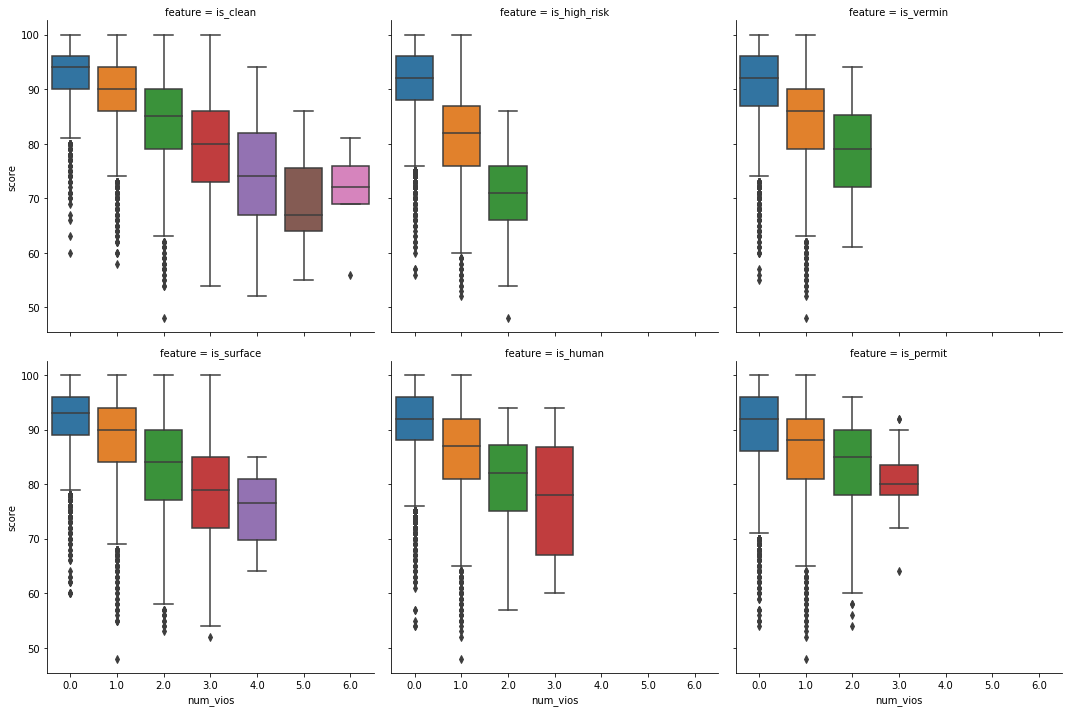

In [41]:
sns.catplot(x='num_vios', y='score',
               col='feature', col_wrap=3,
               kind='box',
               data=violation_type_and_scores)

Above we see, for example, that if a restaurant inspection involved 2 violation with the keyword "vermin", the average score for that inspection would be a little bit below 80.

## Text Processing Example 2: Police Data

In this example, we will apply string processing to the process of data cleaning and exploratory data analysis.

### Getting the Data

The city of Berkeley maintains an [Open Data Portal](https://data.cityofberkeley.info/) for citizens to access data about the city.  We will be examining [Call Data](https://data.cityofberkeley.info/Public-Safety/Berkeley-PD-Calls-for-Service/k2nh-s5h5).

<img src="calls_desc.png" width=800px />



In [ ]:
import ds100_utils

calls_url = 'https://data.cityofberkeley.info/api/views/k2nh-s5h5/rows.csv?accessType=DOWNLOAD'
calls_file = ds100_utils.fetch_and_cache(calls_url, 'calls.csv')
calls = pd.read_csv(calls_file, warn_bad_lines=True)
calls.head()

How many records did we get?

In [ ]:
len(calls)

What does an example `Block_Location` value look like?

In [ ]:
print(calls['Block_Location'].iloc[0])

### Preliminary observations on the data?

1. `EVENTDT` -- Contains the incorrect time
1. `EVENTTM` -- Contains the time in 24 hour format (What timezone?)
1. `CVDOW` -- Encodes the day of the week (see data documentation).
1. `InDbDate` -- Appears to be correctly formatted and appears pretty consistent in time.
1. **`Block_Location` -- a multi-line string that contains coordinates.**
1. `BLKADDR` -- Appears to be the address in `Block Location`.
1. `City` and `State` seem redundant given this is supposed to be the city of Berkeley dataset.

### Extracting locations

The block location contains geographic coordinates. Let's extract them.

In [ ]:
calls['Block_Location'][0]

In [ ]:
calls_lat_lon = (
    calls['Block_Location']
    .str.extract("\((\d+\.\d+)\, (-\d+\.\d+)\)")
)
calls_lat_lon.columns = ['Lat', 'Lon']
calls_lat_lon.head(10)

How many records have missing values?

In [ ]:
calls_lat_lon.isnull().sum()

Examine the missing values.

In [ ]:
calls[calls_lat_lon.isnull().any(axis=1)]['Block_Location'].head(10)

Join in the extracted values.

In [ ]:
if 'Lat' not in calls.columns:
    calls = calls.merge(calls_lat_lon, left_index=True, right_index=True)
calls.head()

## Examining Location information

Let's examine the geographic data (latitude and longitude).  Recall that we had some missing values.  Let's look at the behavior of these missing values according to crime type.

In [ ]:
missing_lat_lon = calls[calls[['Lat', 'Lon']].isnull().any(axis=1)]
missing_lat_lon['CVLEGEND'].value_counts().plot(kind='barh');

In [ ]:
calls['CVLEGEND'].value_counts().plot(kind='barh');

### Observations?

There is a clear bias towards drug violations that is not present in the original data.  Therefore we should be careful when dropping missing values!

We might further normalize the analysis by the frequency to find which type of crime has the highest proportion of missing values.

In [ ]:
(missing_lat_lon['CVLEGEND'].value_counts() 
 / calls['CVLEGEND'].value_counts()
).sort_values(ascending=False).plot(kind="barh");

Now, let's make a crime map.

In [ ]:
import folium
import folium.plugins

SF_COORDINATES = (37.87, -122.28)
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
locs = calls[['Lat', 'Lon']].astype('float').dropna().values
heatmap = folium.plugins.HeatMap(locs.tolist(), radius=10)
sf_map.add_child(heatmap)

### Questions

1. Is campus really the safest place to be?
1. Why are all the calls located on the street and at often at intersections?


In [51]:
locations = calls[calls['CVLEGEND'] == 'ASSAULT'][['Lat', 'Lon']]

cluster = folium.MarkerCluster([])
for _, r in locations.dropna().iterrows():
    cluster.add_child(
        folium.Marker([float(r["Lat"]), float(r["Lon"])]))
    
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=13)
sf_map.add_child(cluster)
sf_map

NameError: name 'calls' is not defined

## Bonus Content: Using Strptime to Extract Time Information

In [ ]:
pd.Series(log_lines).str.extract(pattern)

Date parsing using the `datetime` module.

In [ ]:
from datetime import datetime
datetime.strptime(log_lines[0], '%d/%b/%Y:%H:%M:%S')

In [ ]:
pd.Series(log_lines).str.extract(r'\[(.*) -0800\]')[0].apply(
    lambda s: datetime.strptime(s, '%d/%b/%Y:%H:%M:%S'))